In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Input

In [2]:
data_dir =r"E:\1. Thesis\Update_Code\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [3]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

In [4]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [5]:
def load_images_for_cnn(train_df, 
                        val_df, 
                        test_df, 
                        batch_size=32, 
                        target_size=(224,224)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df,
                                                                        val_df, 
                                                                        test_df, 
                                                                        batch_size=32, 
                                                                        target_size=(224,224))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [6]:
base_model = DenseNet121(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
predictions=Dense(8,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=predictions)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
epochs=10
history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.1806 - loss: 2.0691 - val_accuracy: 0.5150 - val_loss: 1.6434
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 395s 5s/step - accuracy: 0.5474 - loss: 1.5913 - val_accuracy: 0.7250 - val_loss: 1.2712
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.7474 - loss: 1.2648 - val_accuracy: 0.8213 - val_loss: 1.0026
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 358s 5s/step - accuracy: 0.8284 - loss: 1.0293 - val_accuracy: 0.8700 - val_loss: 0.8104
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.8796 - loss: 0.8293 - val_accuracy: 0.8950 - val_loss: 0.6673
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 351s 5s/step - accuracy: 0.9147 - loss: 0.7124 - val_accuracy: 0.9062 - val_loss: 0.5650
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - accuracy: 0.9153 - loss: 0.6047 - val_accuracy: 0.9212 - val_loss: 0.4812
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.9367 - loss: 0.5253 - val_accuracy: 0.9312 - v

In [8]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9295 - loss: 0.3433
Test Loss: 0.3495255410671234, Test Accuracy: 0.9362499713897705


In [9]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step
                  precision    recall  f1-score   support

     Anthracnose       0.96      0.91      0.93       117
Bacterial Canker       0.98      0.99      0.99       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       0.97      0.99      0.98        97
      Gall Midge       0.95      0.86      0.90       107
         Healthy       0.75      1.00      0.86        77
  Powdery Mildew       0.98      0.93      0.95        98
     Sooty Mould       0.88      0.82      0.85        91

        accuracy                           0.94       800
       macro avg       0.93      0.94      0.93       800
    weighted avg       0.94      0.94      0.94       800



In [10]:
test_predictions=model.predict(test_generator)
test_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step


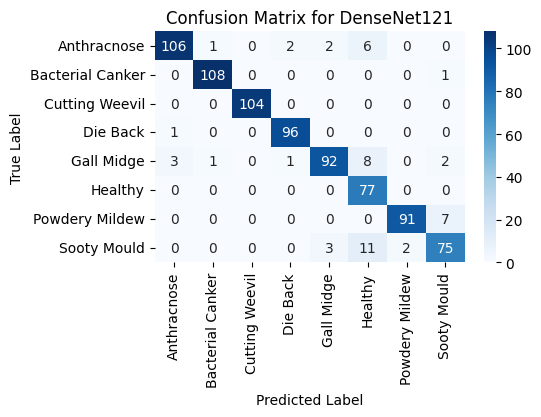

In [11]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,test_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for DenseNet121')
plt.show()

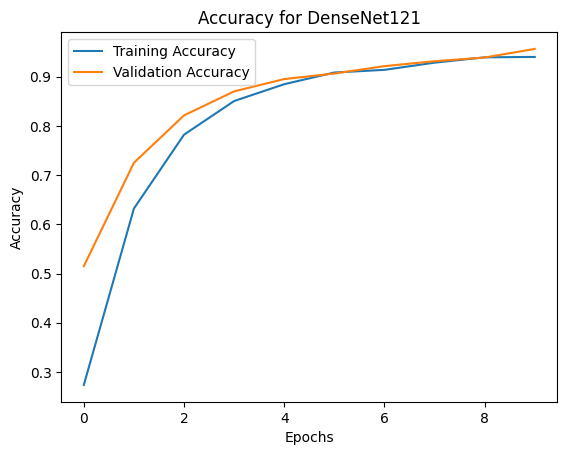

In [12]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for DenseNet121')
plt.legend()
plt.show()

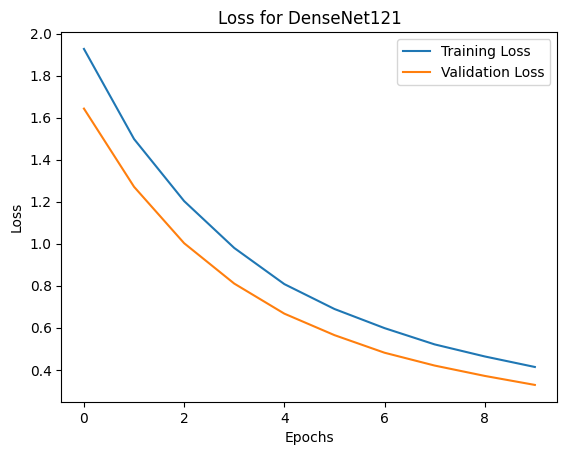

In [13]:
#plot training and validation loss
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for DenseNet121')
plt.legend()
plt.show()

In [14]:
model.save(r'E:\1. Thesis\Update_Code\SavedModel\DenseNet1213F.hdf5')